               Задача кластеризации шести активностей человека

Информация о наборе данных:

Эксперименты проводились с группой из 30 добровольцев в возрастной группе 19-48 лет. Каждый человек выполнил шесть действий (ХОДЬБА, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, СИДЕНИЕ, СТОЯНИЕ, ЛЕЖАНИЕ) в смартфоне (Samsung Galaxy S II) на талии. Используя встроенный акселерометр и гироскоп, мы зафиксировали 3-осевое линейное ускорение и 3-осевую угловую скорость с постоянной скоростью 50 Гц. Эксперименты были записаны на видео, чтобы пометить данные вручную. Полученный набор данных был случайным образом разбит на два набора, где 70% добровольцев были выбраны для генерации обучающих данных и 30% тестовых данных.

Сигналы датчиков (акселерометр и гироскоп) предварительно обрабатывались с применением шумовых фильтров, а затем отбирались в скользящих окнах фиксированной ширины 2,56 сек и 50% перекрытия (128 показаний на окно). Сигнал ускорения датчика, который имеет гравитационную и телесную составляющие, был разделен с помощью фильтра нижних частот Баттерворта на ускорение тела и гравитацию. Предполагается, что гравитационная сила имеет только низкочастотные компоненты, поэтому был использован фильтр с частотой среза 0,3 Гц. Из каждого окна был получен вектор признаков путем вычисления переменных из временной и частотной области.

Информация об атрибутах:

Для каждой записи в наборе данных предусмотрено:
- Трехосное ускорение от акселерометра (суммарное ускорение) и расчетное ускорение тела.
- Трехосная угловая скорость от гироскопа.
- Вектор с 561 признаком с переменными времени и частотной области.
- Его метка деятельности.
- Идентификатор субъекта, проводившего эксперимент.



In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
#warnings.filterwarnings('ignore')
#import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

import sklearn
from sklearn import metrics
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, AffinityPropagation,DBSCAN

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import train_test_split

import catboost
from catboost import Pool,CatBoost
from catboost import CatBoostClassifier
from catboost.utils import eval_metric
from catboost.utils import get_confusion_matrix

import scikitplot as skplt
from scipy.cluster.hierarchy import linkage, dendrogram


In [2]:
X_train = np.loadtxt("C:/Users/анатолий/Documents/datasets/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("C:/Users/анатолий/Documents/datasets/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("C:/Users/анатолий/Documents/datasets/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("C:/Users/анатолий/Documents/datasets/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [3]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((7352, 561), (7352,), (2947, 561), (2947,))

In [4]:
X_train,y_train

(array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
          0.17994061, -0.05862692],
        [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
          0.18028889, -0.05431672],
        [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
          0.18063731, -0.04911782],
        ...,
        [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
          0.24914484,  0.04081119],
        [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
          0.24643223,  0.02533948],
        [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
          0.24680852,  0.03669484]]),
 array([5, 5, 5, ..., 2, 2, 2]))

In [5]:
features = np.concatenate((X_train,X_test), axis=0)
target = np.concatenate((y_train,y_test), axis=0)
features.shape,target.shape

((10299, 561), (10299,))

In [6]:
features

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.34996609,  0.03007744, -0.11578796, ..., -0.65535684,
         0.27447878,  0.18118355],
       [ 0.23759383,  0.01846687, -0.09649893, ..., -0.65971859,
         0.26478161,  0.18756291],
       [ 0.15362719, -0.01843651, -0.13701846, ..., -0.66008023,
         0.26393619,  0.1881034 ]])

In [7]:
target

array([5, 5, 5, ..., 2, 2, 2])

In [8]:
np.unique(target)

array([1, 2, 3, 4, 5, 6])

In [9]:
n_classes = np.unique(target).shape
n_classes

(6,)

Эти метки соответствуют:

1 - ходьба
2 - подъем вверх по лестнице
3 - спуск по лестнице
4 - сидение
5 - стояние
6 - лежка

Посмотрим на распределение наших кластеров

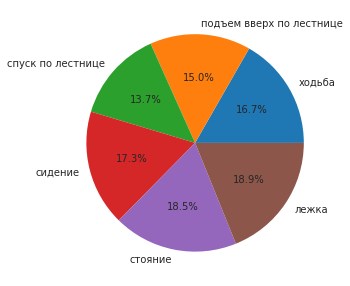

In [10]:
plt.figure(figsize=(9,5))
plt.pie([len([x for x in target if x==1]),
         len([x for x in target if x==2]),
         len([x for x in target if x==3]),
         len([x for x in target if x==4]),
         len([x for x in target if x==5]),
        len([x for x in target if x==6]),],
        labels=['ходьба','подъем вверх по лестнице','спуск по лестнице','сидение','стояние','лежка'],autopct='%.1f%%');
       

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [12]:
X_scaled

array([[ 2.10533854e-01, -6.87026385e-02, -4.52194533e-01, ...,
        -6.74432366e-01,  3.82007658e-01, -1.61505480e-02],
       [ 6.02084832e-02,  3.59023537e-02, -2.75221885e-01, ...,
        -6.81359801e-01,  3.83147865e-01, -1.20627169e-04],
       [ 7.84597052e-02, -4.64269585e-02, -8.55480582e-02, ...,
        -6.89470939e-01,  3.84288531e-01,  1.92144041e-02],
       ...,
       [ 1.11821625e+00,  1.28805864e+00, -1.29414692e-01, ...,
        -3.10750224e-01,  6.91509049e-01,  8.75719123e-01],
       [-5.43492722e-01,  9.75327452e-01,  2.34319837e-01, ...,
        -3.19283719e-01,  6.59762215e-01,  8.99444350e-01],
       [-1.78515253e+00, -1.86663622e-02, -5.29759691e-01, ...,
        -3.19991245e-01,  6.56994458e-01,  9.01454465e-01]])

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных.

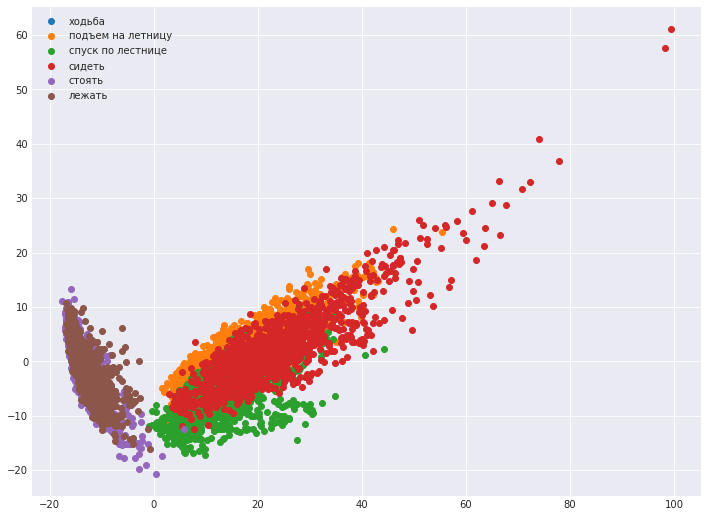

In [13]:
pca = decomposition.PCA(n_components=2)
X_centered = X_scaled - X_scaled.mean(axis=0)
X_pca = pca.fit_transform(X_centered)

# И нарисуем получившиеся точки в  новом пространстве
plt.scatter(X_pca[target == 0, 0], X_pca[target == 0, 1], label='ходьба')
plt.scatter(X_pca[target == 1, 0], X_pca[target == 1, 1], label='подъем на летницу')
plt.scatter(X_pca[target == 2, 0], X_pca[target == 2, 1], label='спуск по лестнице')
plt.scatter(X_pca[target == 3, 0], X_pca[target == 3, 1], label='сидеть')
plt.scatter(X_pca[target == 4, 0], X_pca[target == 4, 1], label='стоять')
plt.scatter(X_pca[target == 5, 0], X_pca[target == 5, 1], label='лежать')


plt.legend(loc=0);

Посмотрим как распределена дисперсия по компонентам

In [14]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,[1,2,3,4,5,6])))
                                            

1 component: 50.74% of initial variance
0.000 x 1 + -0.003 x 2 + -0.002 x 3 + 0.056 x 4 + 0.057 x 5 + 0.054 x 6
2 component: 6.24% of initial variance
0.017 x 1 + 0.001 x 2 + -0.005 x 3 + -0.011 x 4 + -0.024 x 5 + -0.032 x 6


Projecting 561-dimensional data to 2D


Text(0.5, 1.0, ' PCA projection')

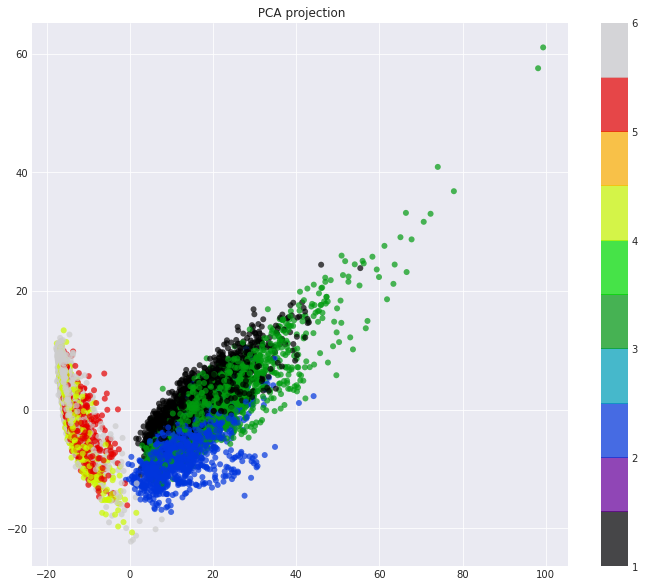

In [15]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

print('Projecting %d-dimensional data to 2D' % X_scaled.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=target, 
            edgecolor='none', alpha=0.7,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title(' PCA projection')

Воспользуемся методом 2_D projection из Sklearn

<AxesSubplot:title={'center':'PCA 2-D Projection'}, xlabel='First Principal Component', ylabel='Second Principal Component'>

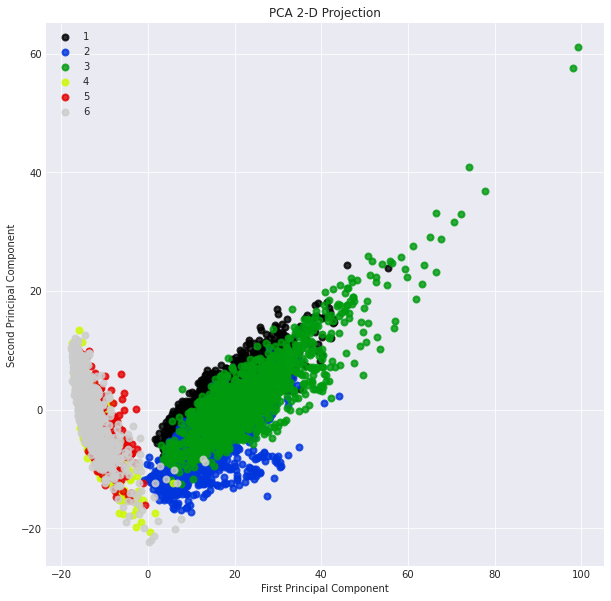

In [16]:
skplt.decomposition.plot_pca_2d_projection(pca, X_scaled, target,
                                           figsize=(10,10),
                                           cmap=plt.cm.get_cmap('nipy_spectral', 10))#"nipy_spectral");


No handles with labels found to put in legend.


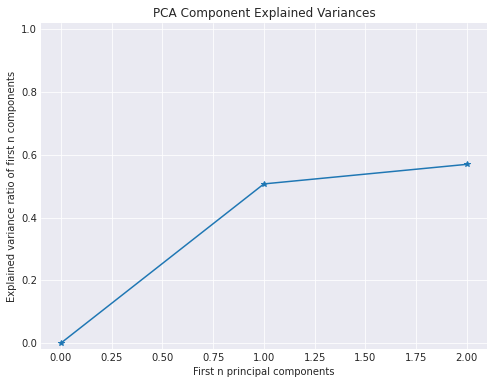

In [17]:
skplt.decomposition.plot_pca_component_variance(pca, figsize=(8,6));

Видим что увеличение числа главных компонент выше 2х уже не сможет увеличить объясненную дисперсию.

Метод t-SNE (t-distributed stochastic neighbor embedding) используем для визуализации отображения пространства высокой размерности в двухмерное пространство.
Метод моделирует каждый объект пространства высокой размерности в двух- или трехкоординатную точку таким образом, что близкие по характеристикам элементы данных в многомерном пространстве (например, датасете с большим числом столбцов) проецируются в соседние точки, а разнородные объекты с большей вероятностью моделируются точками, далеко отстоящими друг от друга
С t-SNE картинка получается  лучше, поскольку у PCA ограничение – он находит только линейные комбинации исходных признаков. 

C:\Python27\bill\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Python27\bill\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Wall time: 2min 14s


Text(0.5, 1.0, ' t-SNE projection')

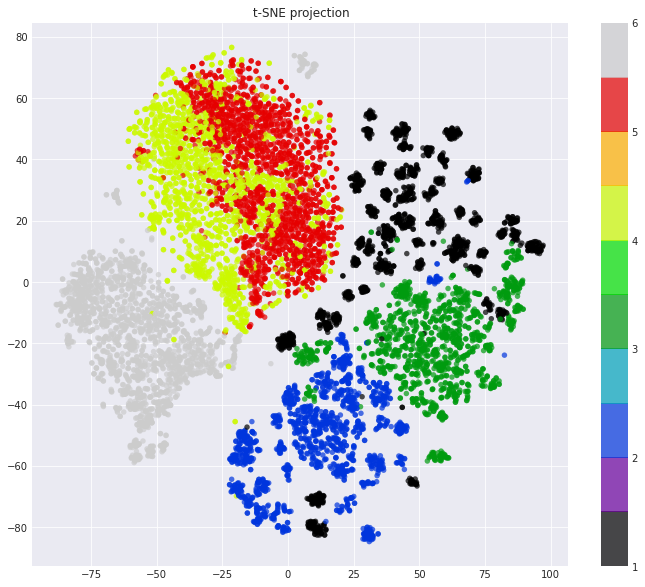

In [18]:
%%time

tsne = TSNE(random_state=12345)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=target, 
            edgecolor='none', alpha=0.7, s=30,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title(' t-SNE projection');

In [19]:
X_tsne

array([[-14.152334 ,  41.30013  ],
       [-24.00139  ,  37.019657 ],
       [-17.234394 ,  44.38223  ],
       ...,
       [  2.5449271, -33.689404 ],
       [  2.4913652, -34.208214 ],
       [  2.4554715, -34.010696 ]], dtype=float32)

In [20]:
X_tsne.shape

(10299, 2)

                           Рассмотрим K-Means модель
                           
Алгоритм К-средних:


1.Выбираем количество кластеров k, которое считаем оптимальным для наших данных.
2.Случайным образом размещаем в пространстве наших данных k точек (центроидов).
3.Для каждой точки  набора данных считаем к какому центроиду она ближе.
4.Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.
5.Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).
                           

Определим количество кластеров

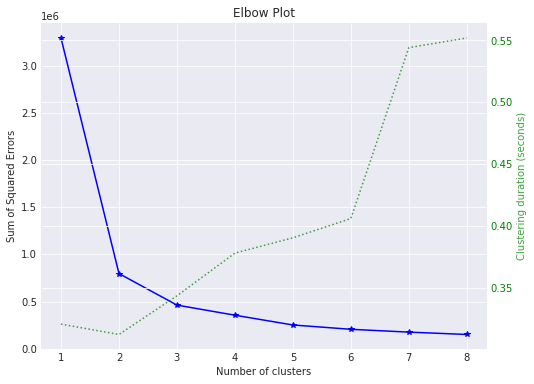

In [21]:
skplt.cluster.plot_elbow_curve(KMeans(random_state=12345),
                               X_pca,
                               cluster_ranges=range(1,9),
                               figsize=(8,6));

Видим что количество кластеров 6 шт соответствует количеству целей

In [22]:

model = KMeans(n_clusters=6,n_init=100, random_state=12345)
model.fit(X_pca)

print("Центроиды кластеров  модели :")
print(model.cluster_centers_)

print("Целевая функция модели:")
print(model.inertia_)


Центроиды кластеров  модели :
[[ 15.82390079  -1.05553279]
 [-12.19279405  -4.04001402]
 [-15.53502695   4.21750664]
 [ 42.95813559  14.38774658]
 [ 25.36167428   3.85561602]
 [  8.34722239  -7.27646807]]
Целевая функция модели:
205690.34790002025


In [23]:
target_km = model.predict(X_pca)

In [24]:
target_km

array([2, 2, 2, ..., 0, 5, 5])

In [25]:
target_km.shape

(10299,)

In [26]:
np.unique(target_km)

array([0, 1, 2, 3, 4, 5])

In [27]:
tab = pd.crosstab(target, target_km, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,845,0,0,44,422,411,1722
подъем вверх по лестнице,430,0,0,3,119,992,1544
спуск по лестнице,465,0,0,169,618,154,1406
сидение,0,645,1117,0,0,15,1777
стояние,0,933,971,0,0,2,1906
лежание,0,553,1364,0,0,27,1944
все,1740,2131,3452,216,1159,1601,10299


Text(0.5, 1.0, ' K-Means')

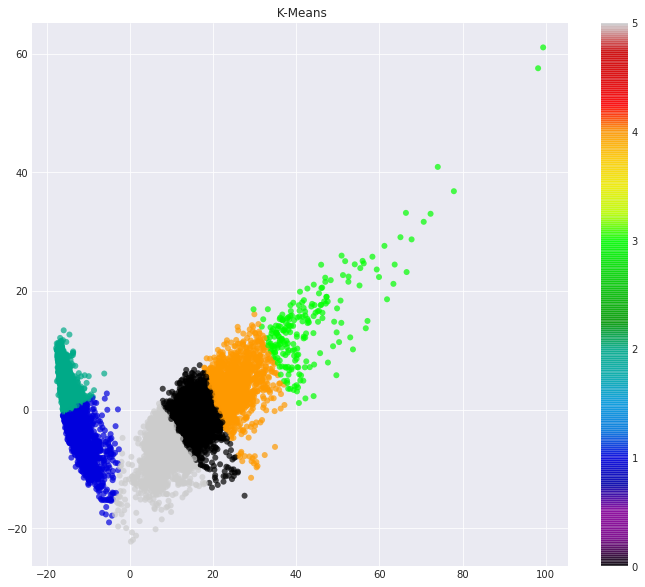

In [28]:
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0],X_pca[:, 1], c=target_km, 
            edgecolor='none', alpha=0.7,
            cmap=plt.cm.get_cmap('nipy_spectral'))
plt.colorbar()
plt.title(' K-Means')

Картинка с разделенными кластерами получилась хорошая.
Теперь рассмотрим метрики 
Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Во-первых, такие оценки не должны зависеть от самих значений меток, а только от самого разбиения выборки. Во-вторых, не всегда известны истинные метки объектов, поэтому также нужны оценки, позволяющие оценить качество кластеризации, используя только неразмеченную выборку.

Выделяют внешние и внутренние метрики качества. Внешние используют информацию об истинном разбиении на кластеры, в то время как внутренние метрики не используют никакой внешней информации и оценивают качество кластеризации, основываясь только на наборе данных. Оптимальное число кластеров обычно определяют с использованием внутренних метрик.

                    Adjusted Rand Index (ARI)

Основное понятие метрики - сумма числа пар объектов с одинаковыми метками и находящимися в одном кластере и числа пар объектов, имеющих различные метки и находящихся в разных кластерах  отнесённая к общему числу объектов в выборке.

Эта мера симметрична, не зависит от значений и перестановок меток. Таким образом, данный индекс является мерой расстояния между различными разбиениями выборки ARI принимает значения в диапазоне [-1, 1]. Отрицательные значения соответствуют "независимым" разбиениям на кластеры, значения, близкие к нулю, — случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи (совпадают при ARI = 1).

In [29]:
print('ARI :', metrics.adjusted_rand_score(target, model.labels_))

ARI : 0.2741388273415687


                     Silhouette 
Это графическое изображение меры плотности группировки объектов в кластере.
Cилуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне -1, 1. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.
С помощью силуэта можно выбирать оптимальное число кластеров k (если оно заранее неизвестно) — выбирается число кластеров, максимизирующее значение силуэта. В отличие от других метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

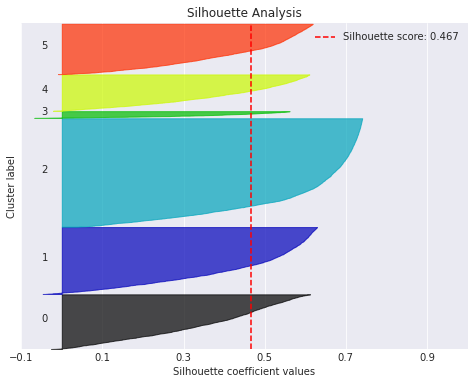

In [30]:
skplt.metrics.plot_silhouette(X_pca, target_km,
                              figsize=(8,6));

In [31]:
print('Silhouette :', metrics.silhouette_score(X_pca, model.labels_))

Silhouette : 0.46682748407620056


         AMI

Данная мера очень похожа ARI метрику. Она также симметрична, не зависит от значений и перестановок меток. Определяется с использованием функции энтропии, интерпретируя разбиения выборки, как дискретные распределения (вероятность отнесения к кластеру равна доле объектов в нём).
Он принимает значения в диапазоне 0, 1. Значения, близкие к нулю, говорят о независимости разбиений, а близкие к единице – об их схожести (совпадении при AMI = 1).

In [32]:
print('AMI :', metrics.adjusted_mutual_info_score(target, model.labels_))

AMI : 0.4412349145462367


                      V-мера 
Это аналог F1-меры и определяется как среднее гармоническое между значением насколько каждый кластер состоит из объектов
одного класса и значением насколько объекты одного класса относятся к одному кластеру.


In [33]:
print('V-measure :', metrics.v_measure_score(target, model.labels_))

V-measure : 0.441635194188799


                      Рассмотрим агломеративную кластеризацию

In [34]:
model_ag = AgglomerativeClustering(n_clusters=6, 
                             linkage='ward')

In [35]:
target_ag = model_ag.fit_predict(X_pca)

In [36]:
target_ag

array([0, 0, 4, ..., 2, 2, 2], dtype=int64)

In [37]:
tab_ag = pd.crosstab(target, target_ag, margins=True)
tab_ag.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab_ag.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab_ag

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,89,647,626,0,360,1722
подъем вверх по лестнице,3,10,873,499,0,159,1544
спуск по лестнице,0,248,186,369,0,603,1406
сидение,1021,0,2,0,754,0,1777
стояние,1362,0,1,0,543,0,1906
лежание,949,0,10,2,983,0,1944
все,3335,347,1719,1496,2280,1122,10299


Text(0.5, 1.0, ' AgglomerativeClustering')

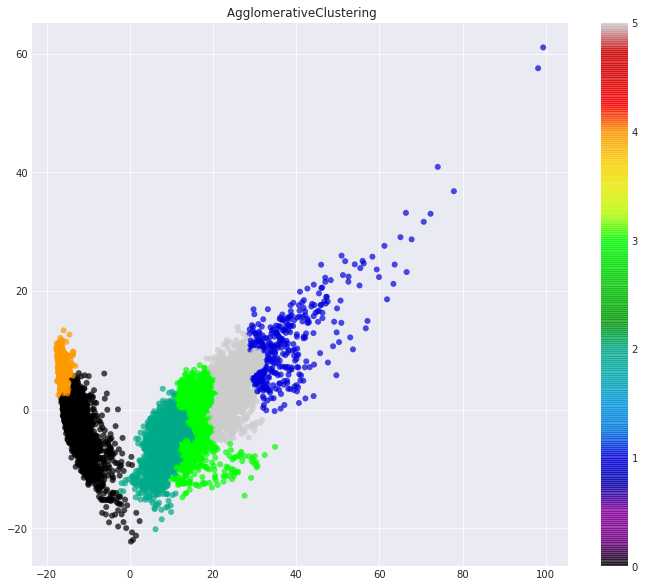

In [38]:
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0],X_pca[:, 1], c=target_ag, 
            edgecolor='none', alpha=0.7,
            cmap=plt.cm.get_cmap('nipy_spectral'))
plt.colorbar()
plt.title(' AgglomerativeClustering')

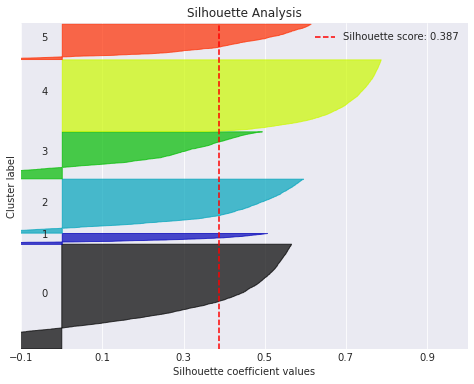

In [39]:
skplt.metrics.plot_silhouette(X_pca, target_ag,
                              figsize=(8,6));

In [40]:
print('ARI :', metrics.adjusted_rand_score(target, model_ag.labels_))

ARI : 0.2625750496345055


In [41]:
print('AMI :', metrics.adjusted_mutual_info_score(target, model_ag.labels_))

AMI : 0.433468844883479


In [42]:
print('V-measure :', metrics.v_measure_score(target, model_ag.labels_))

V-measure : 0.43387158549006055


            Рассмотрим модель  DBSCAN

In [43]:
model_db = DBSCAN(eps = 3.25,
                 min_samples = 95,
                 metric = 'euclidean')
target_db = model_db.fit_predict(X_pca)

In [44]:
target_db

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

Text(0.5, 1.0, 'DBSCAN ')

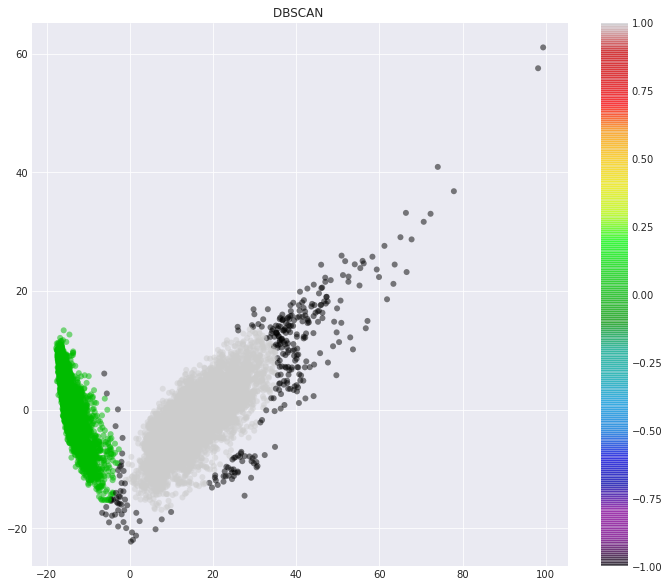

In [45]:
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0],X_pca[:, 1], c=target_db, 
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral'))
plt.colorbar()
plt.title('DBSCAN ')

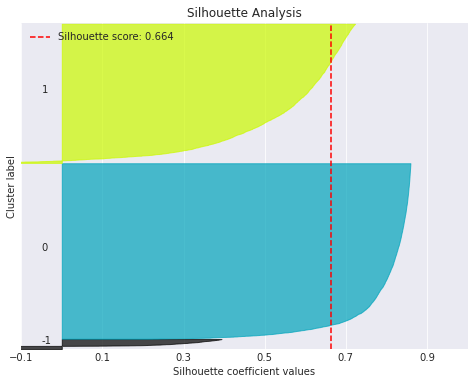

In [46]:
skplt.metrics.plot_silhouette(X_pca, target_db,
                              figsize=(8,6));

In [47]:
print('ARI :', metrics.adjusted_rand_score(target, model_db.labels_))

ARI : 0.32738738420436647


In [48]:
tab_db = pd.crosstab(target, target_db, margins=True)
tab_db.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab_db.columns = ['cluster' + str(i + 1) for i in range(3)] + ['все']
tab_db

,cluster1,cluster2,cluster3,все
ходьба,46,0,1676,1722
подъем вверх по лестнице,45,0,1499,1544
спуск по лестнице,176,0,1230,1406
сидение,18,1758,1,1777
стояние,6,1900,0,1906
лежание,26,1910,8,1944
все,317,5568,4414,10299


При заданных гиперпараметрах DBSCAN определил три кластера.

    Рассмотрим многоклассовую задачу классификации используя СatBoostClassifier

In [49]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, 
                                                    stratify=target, 
                                                    random_state=12345)

In [50]:
features_train.shape, features_test.shape, target_train.shape,target_test.shape

((7724, 561), (2575, 561), (7724,), (2575,))

In [59]:
booster = CatBoostClassifier(iterations=100,
                             #classes_count=len(target),
                             eval_metric= 'Accuracy')

booster.fit(features_train, target_train,
            eval_set=(features_test, target_test),
            plot=True)

test_preds = booster.predict(features_test)
train_preds = booster.predict(features_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.271072
0:	learn: 0.8608234	test: 0.8590291	best: 0.8590291 (0)	total: 2.01s	remaining: 3m 18s
1:	learn: 0.8744174	test: 0.8675728	best: 0.8675728 (1)	total: 4.47s	remaining: 3m 38s
2:	learn: 0.8847747	test: 0.8792233	best: 0.8792233 (2)	total: 6.53s	remaining: 3m 30s
3:	learn: 0.8981098	test: 0.8924272	best: 0.8924272 (3)	total: 8s	remaining: 3m 11s
4:	learn: 0.9089850	test: 0.9001942	best: 0.9001942 (4)	total: 9.51s	remaining: 3m
5:	learn: 0.9135163	test: 0.9052427	best: 0.9052427 (5)	total: 11.1s	remaining: 2m 53s
6:	learn: 0.9193423	test: 0.9102913	best: 0.9102913 (6)	total: 12.5s	remaining: 2m 46s
7:	learn: 0.9208959	test: 0.9133981	best: 0.9133981 (7)	total: 14.1s	remaining: 2m 42s
8:	learn: 0.9245210	test: 0.9180583	best: 0.9180583 (8)	total: 15.7s	remaining: 2m 38s
9:	learn: 0.9289228	test: 0.9203883	best: 0.9203883 (9)	total: 17.1s	remaining: 2m 34s
10:	learn: 0.9333247	test: 0.9234951	best: 0.9234951 (10)	total: 18.6s	remaining: 2m 30s
11:	learn: 0.93798

In [60]:
print("\nПравильность на тесте : %.2f"%booster.score(features_test, target_test))
print("\nПравильность на обучении : %.2f"%booster.score(features_train, target_train))


Правильность на тесте : 0.98

Правильность на обучении : 1.00


In [61]:
r = sklearn.metrics.multilabel_confusion_matrix(target_test, test_preds,
           labels=[1,2,3,4,5,6])
print(r)

[[[2141    3]
  [  10  421]]

 [[2181    8]
  [   3  383]]

 [[2218    6]
  [   4  347]]

 [[2119   12]
  [  20  424]]

 [[2078   20]
  [  12  465]]

 [[2089    0]
  [   0  486]]]


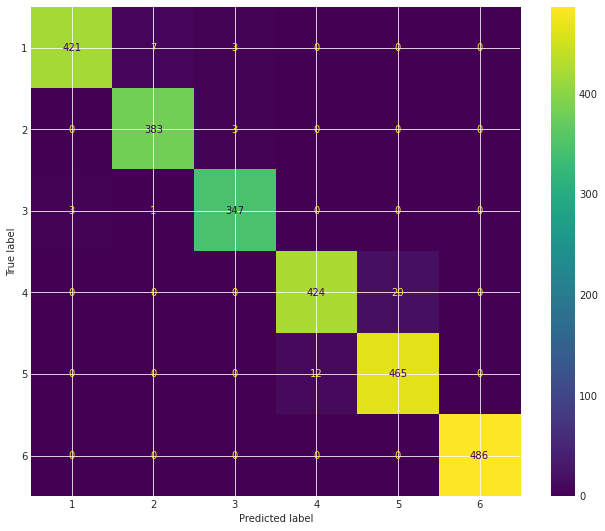

In [62]:
fig, ax = plt.subplots(figsize=(11, 9))

cm = confusion_matrix(target_test, test_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=booster.classes_[:6])
cmp.plot(ax=ax)

In [63]:
print(classification_report(target_test, test_preds))

              precision    recall  f1-score   support

           1       0.99      0.98      0.98       431
           2       0.98      0.99      0.99       386
           3       0.98      0.99      0.99       351
           4       0.97      0.95      0.96       444
           5       0.96      0.97      0.97       477
           6       1.00      1.00      1.00       486

    accuracy                           0.98      2575
   macro avg       0.98      0.98      0.98      2575
weighted avg       0.98      0.98      0.98      2575



Из полученных результатов видим,что задача определения 6 классов при использовании CatBoostClassifier отработана отлично
даже не используя подбор гиперпараметров